# 癌症检测项目
在这个小项目中，你要设计一个算法，使其能对最致命的皮肤癌——黑色素瘤进行视觉诊断。你的算法应特别能将这种恶性皮肤肿瘤与两种良性病变（黑色素痣和脂溢性角化病）区分开来。
数据和目标来自国际皮肤影像协作组织 2017 年黑色素瘤检测的皮肤病变分析挑战。作为挑战的一部分，参与者需要设计一个算法，用于诊断三种不同皮肤病的其中之一（黑色素瘤、黑色素痣或脂溢性角化病）的皮肤病变图像。在该项目中，你要创建一个模型，用于生成你自己的预测结果。


In [120]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import sys
from sklearn.preprocessing import LabelBinarizer
from keras import __version__
from keras.applications.inception_v3 import InceptionV3,preprocess_input,decode_predictions
from keras.applications.resnet50 import ResNet50,preprocess_input,decode_predictions
from keras.models import Model,Sequential
from keras.layers import Dropout,Dense,GlobalAveragePooling2D
from keras.optimizers import SGD
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.utils import plot_model
import tensorflow as tf
import pickle as pkl
%matplotlib inline

In [85]:
print('TensorFlow Version:', tf.__version__)
print('Keras Version:', __version__)

TensorFlow Version: 1.0.0
Keras Version: 2.0.0


In [87]:
# 数据准备：使用 OS 库创建在训练、测试和验证文件夹中所有图像的列表创建标签的One-Hot编码
top_level_train = os.listdir("data/train/train")
top_level_valid = os.listdir("data/valid/valid")
top_level_test = os.listdir("data/test/test")

In [88]:
print(top_level_train,top_level_valid,top_level_test)

['melanoma', 'nevus', 'seborrheic_keratosis'] ['melanoma', 'nevus', 'seborrheic_keratosis'] ['melanoma', 'nevus', 'seborrheic_keratosis']


In [89]:
#滚动浏览文件的所有目录并生成所有图像的列表。
def file_parser(high_level,dirs):
    files=[]
    for directory in dirs:
        for file in os.listdir(high_level + directory):
            files.append(directory +'/' + file)
    return files
train_files = file_parser('data/train/train/',top_level_train)
valid_files = file_parser('data/valid/valid/',top_level_valid)
test_files = file_parser('data/test/test/',top_level_test)

In [90]:
print(len(train_files),len(test_files),len(valid_files))

2000 600 150


In [92]:
#设置图像宽度和高度
IM_WIDTH = 299
IM_HEIGHT = 299

In [93]:
def img_prep(img_path):
    '''
    函数从图像路径中提取图像并返回图像的 numpy 数组。
    返回的图像的大小将由 IM_WIDTH 和 IM_HEIGHT 定义 (上面定义)
    '''
    img = image.load_img(img_path,target_size=(IM_WIDTH,IM_HEIGHT))
    return image.img_to_array(img)

## 从图像路径获取数据和对应标签

In [94]:
trn_files = []
trn_labels = []
for file in train_files:
    trn_files.append(img_prep('data/train/train/' + file))
    dir_file = file.split('/')
    trn_labels.append(dir_file[0])

In [95]:
tst_files = []
tst_labels = []
for file in test_files:
    tst_files.append(img_prep('data/test/test/' + file))
    dir_file = file.split('/')
    tst_labels.append(dir_file[0])

In [96]:
vld_files = []
vld_labels = []
for file in valid_files:
    vld_files.append(img_prep('data/valid/valid/' + file))
    dir_file = file.split('/')
    vld_labels.append(dir_file[0])

In [97]:
#all_files = [trn_files, trn_labels, tst_files, tst_labels, vld_files, vld_labels]
def convert_to_array(lst):
    return np.asarray(lst)

trn_files = convert_to_array(trn_files)
trn_labels = convert_to_array(trn_labels)
tst_files = convert_to_array(tst_files)
tst_labels = convert_to_array(tst_labels)
vld_files = convert_to_array(vld_files)
vld_labels = convert_to_array(vld_labels)

In [98]:
print(type(trn_files))

<class 'numpy.ndarray'>


## 使用pickle保存所有图像数据和标签以节省数据准备时间
## 在下次要运行分析时, 从磁盘加载数据会通过利用以下步骤节省时间。

In [99]:
print(len(trn_files),len(trn_labels))
with open('pickled/trn_files.pkl', 'wb') as f:
    pkl.dump(trn_files, f)
with open('pickled/trn_labels.pkl', 'wb') as f:
    pkl.dump(trn_labels, f)

2000 2000


In [100]:
print(len(tst_files), len(tst_labels))
with open('pickled/tst_files.pkl', 'wb') as f:
    pkl.dump(tst_files, f)
with open('pickled/tst_labels.pkl', 'wb') as f:
    pkl.dump(tst_labels, f)

600 600


In [101]:
print(len(vld_files), len(vld_labels))
with open('pickled/vld_files.pkl', 'wb') as f:
    pkl.dump(vld_files, f)
with open('pickled/vld_labels.pkl', 'wb') as f:
    pkl.dump(vld_labels, f)

150 150


使用此项可在启动笔记本后跳过数据准备

In [102]:
#Load Pickled Datasets
with open('pickled/trn_files.pkl', 'rb') as f:
    trn_files = pkl.load(f)
with open('pickled/trn_labels.pkl', 'rb') as f:
    trn_labels = pkl.load(f)
with open('pickled/tst_files.pkl', 'rb') as f:
    tst_files = pkl.load(f)
with open('pickled/tst_labels.pkl', 'rb') as f:
    tst_labels = pkl.load(f)
with open('pickled/vld_files.pkl', 'rb') as f:
    vld_files = pkl.load(f)
with open('pickled/vld_labels.pkl', 'rb') as f:
    vld_labels = pkl.load(f)

In [103]:
#将labels转成One-hot的向量
lb = LabelBinarizer()
lb.fit(trn_labels)
trn_label_vecs = lb.transform(trn_labels)
test_lb = LabelBinarizer()
test_lb.fit(tst_labels)
tst_label_vecs = test_lb.transform(tst_labels)
valid_lb = LabelBinarizer()
valid_lb.fit(vld_labels)
vld_label_vecs = valid_lb.transform(vld_labels)

In [104]:
print(vld_label_vecs)

[[1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 

In [105]:
#Shuffle the Data
def randomize_data(files,labels):
    randomize = np.arange(len(files))
    np.random.shuffle(randomize)
    return trn_files[randomize],trn_label_vecs[randomize]

trn_files, trn_label_vecs = randomize_data(trn_files, trn_label_vecs)
tst_files, tst_label_vecs = randomize_data(tst_files, tst_label_vecs)
vld_files, vld_label_vecs = randomize_data(vld_files, vld_label_vecs)

In [106]:
print(len(trn_label_vecs), len(trn_files))
print(type(trn_label_vecs), type(trn_files))

2000 2000
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [107]:
print(len(tst_label_vecs),len(tst_files))

600 600


In [108]:
Melanoma = 0
Nevus = 0 
Seborrheic_Keratosis = 0
for lable in trn_labels:
    if lable == 'melanoma':
        Melanoma += 1
    if lable == 'nevus':
        Nevus += 1
    if lable == 'seborrheic_keratosis':
        Seborrheic_Keratosis += 1
print(Melanoma,Nevus,Seborrheic_Keratosis)

374 1372 254


# 创建迁移学习的模型

add_new_last_layer 函数将两个室友relu 激活函数的新的完全连接的层添加到模型中。该函数最后添加一个 softmax 层来处理模型的预测。

In [109]:
def add_new_last_layer(base_model,nb_classes,fc_size,fc_size2,drop):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(fc_size,activation='relu')(x)
    x = Dropout(drop)(x)
    x = Dense(fc_size2,activation='relu')(x)
    x = Dropout(drop)(x)
    predictions = Dense(nb_classes,activation='softmax')(x)
    model = Model(inputs=base_model.input,outputs=predictions)
    return model

In [110]:
#Model Hyperparamaters
nb_classes = 3
fc_size = 512
fc_size2 = 256
batch_sizes = 100
dropout = 0.5

In [121]:
base_model = InceptionV3(weights='imagenet',include_top=False)
model = add_new_last_layer(base_model,nb_classes,fc_size,fc_size2,dropout)

In [122]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_4 (InputLayer)             (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, None, None, 32 864                                          
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, None, None, 32 96                                           
____________________________________________________________________________________________________
activation_148 (Activation)      (None, None, None, 32 0                                            
___________________________________________________________________________________________

In [123]:
model.save_weights('save_models/ResNet50_baseline.h5')

In [124]:
i = 0
for layer in model.layers:
    i += 1
print(i)

317


In [125]:
def setup_to_transfer_learn(model):
    #冻结所有 pretrained 层并编译模式
    for layer in model.layers[:181]:
        layer.trainable = False
        model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

In [126]:
setup_to_transfer_learn(model)

In [130]:
epoch = 20
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5',verbose=1,save_best_only=True)
early_stoping = EarlyStopping(monitor='val_loss',min_delta=0.001,patience=4,verbose=1,mode='auto')
#训练模型
hist = model.fit(np.array(trn_files),np.array(trn_label_vecs),validation_data=(np.array(vld_files),np.array(vld_label_vecs)),batch_size= batch_sizes,epochs=epoch,callbacks=[checkpointer,early_stoping],verbose=1)

Train on 2000 samples, validate on 150 samples
Epoch 1/20
2000/2000 [==============================] - 1595s - loss: 0.9353 - acc: 0.6625 - val_loss: 2.4471 - val_acc: 0.7267
Epoch 2/20
2000/2000 [==============================] - 1600s - loss: 0.8049 - acc: 0.6815 - val_loss: 3.2910 - val_acc: 0.7267
Epoch 3/20
2000/2000 [==============================] - 1650s - loss: 0.7288 - acc: 0.7070 - val_loss: 2.5074 - val_acc: 0.7267
Epoch 4/20
2000/2000 [==============================] - 1593s - loss: 0.6389 - acc: 0.7725 - val_loss: 3.1587 - val_acc: 0.5933
Epoch 5/20
2000/2000 [==============================] - 1547s - loss: 0.6334 - acc: 0.7935 - val_loss: 1.2684 - val_acc: 0.7867
Epoch 6/20
2000/2000 [==============================] - 1596s - loss: 0.5404 - acc: 0.8230 - val_loss: 1.9829 - val_acc: 0.8000
Epoch 7/20
2000/2000 [==============================] - 3218s - loss: 0.4714 - acc: 0.8620 - val_loss: 2.9299 - val_acc: 0.7667
Epoch 8/20
2000/2000 [==============================] - 2

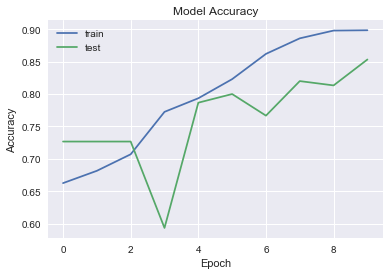

In [138]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

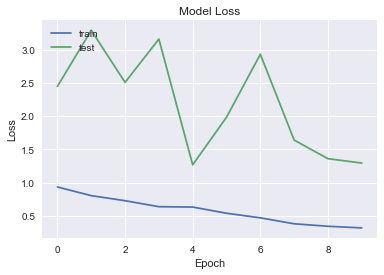

In [139]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# 模型预测

In [133]:
'''
此函数接受上面的最终模型, 并返回所有所有三类型的分类。
img_matrix: 图像数据的numpy 阵列形式
'''
def predict_image(model,image_matrix):
    img = np.expand_dims(image_matrix,axis=0)
    img = preprocess_input(img)
    return model.predict(img)
'''
此函数接受 numpy 数组的预测值, 并返回每个标签的预测字典。
'''
def convert_prediction(values):
    labels = ['Melanoma', 'Nevus', 'Seborrheic Keratosis']
    value_hash = {}
    for i in range(len(labels)):
        value_hash[labels[i]] = values[0][1]
    return value_hash


In [134]:
values = predict_image(model, trn_files[0])
predictions = convert_prediction(values)

In [135]:
trn_label_vecs[0]

array([1, 0, 0])

In [136]:
print(predictions['Melanoma'])

1.0
